In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from sklearn.model_selection import ParameterGrid

# Load the dataset
file_path = 'data/monatszahlen2405_verkehrsunfaelle_export_31_05_24_r.csv'
data = pd.read_csv(file_path, usecols=['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT'])

In [25]:
# Rename columns to English for easier interpretation
data.columns = ['category', 'type', 'year', 'month', 'value']

# Translate category values to English
category_map = {
    "Alkoholunfälle": "alcohol",
    "Fluchtunfälle": "escape",
    "Verkehrsunfälle": "traffic"
}
data['category'] = data['category'].map(category_map)

# Translate type values to English
type_map = {
    "insgesamt": "total",
    "Verletzte und Getötete": "injured_and_killed",
    "Verletzte": "injured"
}
data['type'] = data['type'].map(type_map)

# Remove rows where month contains 'Summe'
data = data[~data['month'].astype(str).str.contains('Summe')]

# Convert month to int
data['month'] = data['month'].astype(int)

# Extract month from 'month' column (assuming it is in yyyymm format)
data['month'] = data['month'] % 100

# Impute missing values using the mean of that month of that year
data['value'] = data.groupby(['year', 'month', 'category', 'type'])['value'].transform(lambda x: x.fillna(x.mean()))

# Drop rows where the entire month-year-category-type combination has no values
data.dropna(subset=['value'], inplace=True)

# Create a date column for easier time series handling
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))

# Sort data by date to ensure proper time series ordering
data = data.sort_values(by='date')

# Split the data into training and testing sets
train_data = data[data['year'] <= 2020]
test_data = data[data['year'] > 2020]

# Descriptive statistics for each category and type
print("Descriptive Statistics for Each Category and Type (Training Data):")
train_data.groupby(['category', 'type'])['value'].describe()

Descriptive Statistics for Each Category and Type (Training Data):


count         mean         std     min      25%  \
category type                                                                  
alcohol  injured_and_killed  252.0    20.698413   10.671308     0.0    12.75   
         total               252.0    43.753968   18.069448    10.0    30.75   
escape   injured_and_killed  252.0    44.888889   14.993078    17.0    34.00   
         total               252.0   879.428571  135.216334   411.0   793.75   
traffic  injured_and_killed  252.0   511.531746  148.671149   192.0   390.50   
         total               252.0  3537.198413  479.649632  2251.0  3205.75   

                                50%      75%     max  
category type                                         
alcohol  injured_and_killed    20.0    27.00    53.0  
         total                 40.0    53.25   107.0  
escape   injured_and_killed    43.0    55.00    85.0  
         total                877.5   966.25  1187.0  
traffic  injured_and_killed   508.0   610.25   976.0  
         total               3487.0  3906.75  4763.0

In [ ]:
# AutoARIMA Model (Alcohol Category - Total Type)
alcohol_total_series = train_data[(train_data['category'] == 'alcohol') & (train_data['type'] == 'total')].set_index('date')['value']

# Fit AutoARIMA model
auto_arima_model = auto_arima(alcohol_total_series, seasonal=True, m=12, trace=False, error_action='ignore', suppress_warnings=True)

# Forecast for the next 12 months with AutoARIMA
auto_arima_forecast = auto_arima_model.predict(n_periods=len(test_data[(test_data['category'] == 'alcohol') & (test_data['type'] == 'total')]))

auto_arima_forecast_index = test_data[(test_data['category'] == 'alcohol') & (test_data['type'] == 'total')].set_index('date').index[:len(auto_arima_forecast)]

# SARIMA Model for alcohol category with type total
sarima_model = SARIMAX(alcohol_total_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)

# Forecast for the next 12 months with SARIMA
sarima_forecast = sarima_result.get_forecast(steps=len(test_data[(test_data['category'] == 'alcohol') & (test_data['type'] == 'total')]))
sarima_forecast_mean = sarima_forecast.predicted_mean
sarima_forecast_ci = sarima_forecast.conf_int()

# LSTM Model Preparation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(alcohol_total_series.values.reshape(-1, 1))

# Create sequences for LSTM
sequence_length = 12
X, y = [], []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i + sequence_length])
    y.append(scaled_data[i + sequence_length])
X, y = np.array(X), np.array(y)

# Split into training and testing datasets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
lstm_model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=32, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions for the next few months
lstm_predictions = []
input_sequence = X_test[-1]  # Start with the last sequence from the test set

for _ in range(len(test_data[(test_data['category'] == 'alcohol') & (test_data['type'] == 'total')])):  # Predict for test set length
    next_value = lstm_model.predict(input_sequence.reshape(1, sequence_length, 1))
    lstm_predictions.append(next_value[0, 0])
    input_sequence = np.append(input_sequence[1:], next_value, axis=0)

# Rescale the LSTM predictions back to original scale
lstm_predictions_rescaled = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1))

# Prepare the data for Prophet
alcohol_total_prophet = train_data[(train_data['category'] == 'alcohol') & (train_data['type'] == 'total')][['date', 'value']].rename(columns={'date': 'ds', 'value': 'y'})

# Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality': [False],
    'yearly_seasonality': [True],
    'daily_seasonality': [False]
}

# Generate all combinations of parameters
all_params = list(ParameterGrid(param_grid))

# Store the results
best_mae = float('inf')
best_params = None
best_model = None

test_alcohol_total_series = test_data[(test_data['category'] == 'alcohol') & (test_data['type'] == 'total')].set_index('date')['value']

for params in all_params:
    m = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        weekly_seasonality=params['weekly_seasonality'],
        yearly_seasonality=params['yearly_seasonality'],
        daily_seasonality=params['daily_seasonality']
    )
    # Fit the model
    m.fit(alcohol_total_prophet)
    # Make future dataframe
    future = m.make_future_dataframe(periods=len(test_alcohol_total_series), freq='MS')
    # Predict
    forecast = m.predict(future)
    # Extract forecasted values
    forecast_values = forecast['yhat'][-len(test_alcohol_total_series):].values
    # Calculate MAE
    mae = mean_absolute_error(test_alcohol_total_series, forecast_values)
    # Update best params if current MAE is better
    if mae < best_mae:
        best_mae = mae
        best_params = params
        best_model = m
        best_forecast = forecast

print(f"Best MAE for Prophet: {best_mae}")
print(f"Best Parameters for Prophet: {best_params}")

# Get the forecasted values from the best model
forecast_values_prophet = best_forecast['yhat'][-len(test_alcohol_total_series):].values

# Calculate metrics for Prophet model
mae_prophet = mean_absolute_error(test_alcohol_total_series, forecast_values_prophet)
rmse_prophet = np.sqrt(mean_squared_error(test_alcohol_total_series, forecast_values_prophet))
r2_prophet = r2_score(test_alcohol_total_series, forecast_values_prophet)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1279 
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0323
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0285 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0186
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0262
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0191 
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0218
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0192 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0171 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0174 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0194 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0192
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0209
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0191
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0180
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms

18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1] done processing
18:08:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1] done processing
18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Best MAE for Prophet: 7.010735077872976
Best Parameters for Prophet: {'changepoint_prior_scale': 0.5, 'daily_seasonality': False, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False, 'yearly_seasonality': True}
Mean Absolute Error (MAE) for Prophet model: 7.010735077872976
Root Mean Squared Error (RMSE) for Prophet model: 8.875039685182493
R^2 Score for Prophet model: 0.6148345749947963


In [37]:
# Calculate metrics for AutoARIMA, SARIMA, and LSTM models
# Align forecast and test data
test_forecast_values_arima = auto_arima_forecast[:len(test_alcohol_total_series)]
test_forecast_values_sarima = sarima_forecast_mean[:len(test_alcohol_total_series)]
test_forecast_values_lstm = lstm_predictions_rescaled.flatten()[:len(test_alcohol_total_series)]

# Calculate metrics
mae_arima = mean_absolute_error(test_alcohol_total_series, test_forecast_values_arima)
mae_sarima = mean_absolute_error(test_alcohol_total_series, test_forecast_values_sarima)
mae_lstm = mean_absolute_error(test_alcohol_total_series, test_forecast_values_lstm)

rmse_arima = np.sqrt(mean_squared_error(test_alcohol_total_series, test_forecast_values_arima))
rmse_sarima = np.sqrt(mean_squared_error(test_alcohol_total_series, test_forecast_values_sarima))
rmse_lstm = np.sqrt(mean_squared_error(test_alcohol_total_series, test_forecast_values_lstm))

r2_arima = r2_score(test_alcohol_total_series, test_forecast_values_arima)
r2_sarima = r2_score(test_alcohol_total_series, test_forecast_values_sarima)
r2_lstm = r2_score(test_alcohol_total_series, test_forecast_values_lstm)

print(f'MAE for Prophet model: {mae_prophet}')
print(f'MAE for AutoARIMA model: {mae_arima}')
print(f'MAE for SARIMA model: {mae_sarima}')
print(f'MAE for LSTM model: {mae_lstm} \n')

print(f'RMSE for Prophet model: {rmse_prophet}')
print(f'RMSE for AutoARIMA model: {rmse_arima}')
print(f'RMSE for SARIMA model: {rmse_sarima}')
print(f'RMSE for LSTM model: {rmse_lstm} \n')

print(f'R^2 Score for Prophet model: {r2_prophet}')
print(f'R^2 Score for AutoARIMA model: {r2_arima}')
print(f'R^2 Score for SARIMA model: {r2_sarima}')
print(f'R^2 Score for LSTM model: {r2_lstm}')

MAE for Prophet model: 7.010735077872976
MAE for AutoARIMA model: 8.15806019607175
MAE for SARIMA model: 7.565284465090819
MAE for LSTM model: 11.676225821177164 

RMSE for Prophet model: 8.875039685182493
RMSE for AutoARIMA model: 9.573097128798398
RMSE for SARIMA model: 8.962462193452922
RMSE for LSTM model: 13.842550377067036 

R^2 Score for Prophet model: 0.6148345749947963
R^2 Score for AutoARIMA model: 0.5518621582522829
R^2 Score for SARIMA model: 0.607209151251477
R^2 Score for LSTM model: 0.06300146238807458


/var/folders/6l/rd9mz6093d1688p05vb4jvk80000gn/T/ipykernel_12459/3008702126.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=mae_values, palette='viridis')


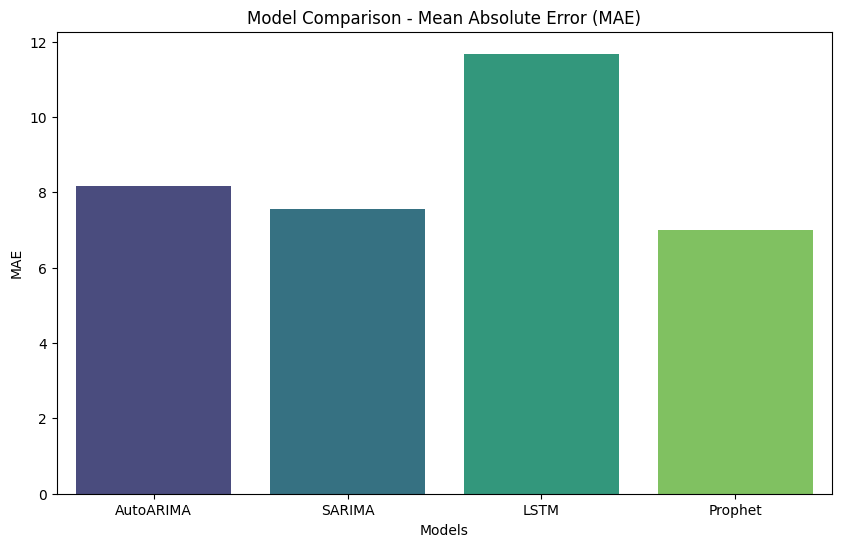

/var/folders/6l/rd9mz6093d1688p05vb4jvk80000gn/T/ipykernel_12459/3008702126.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=rmse_values, palette='viridis')


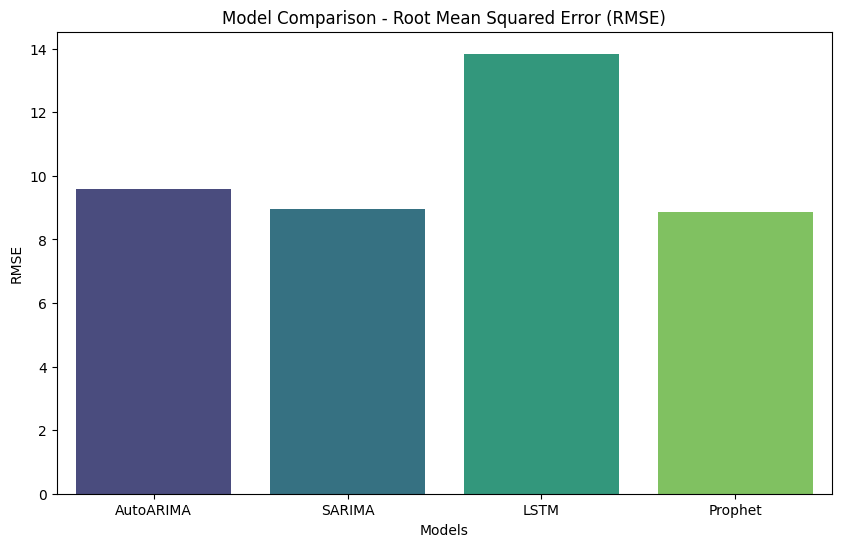

/var/folders/6l/rd9mz6093d1688p05vb4jvk80000gn/T/ipykernel_12459/3008702126.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=r2_values, palette='viridis')


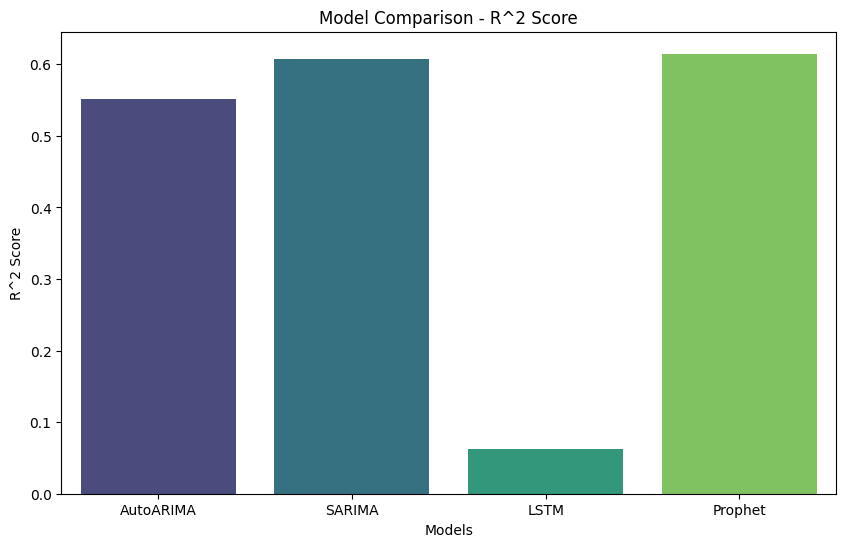

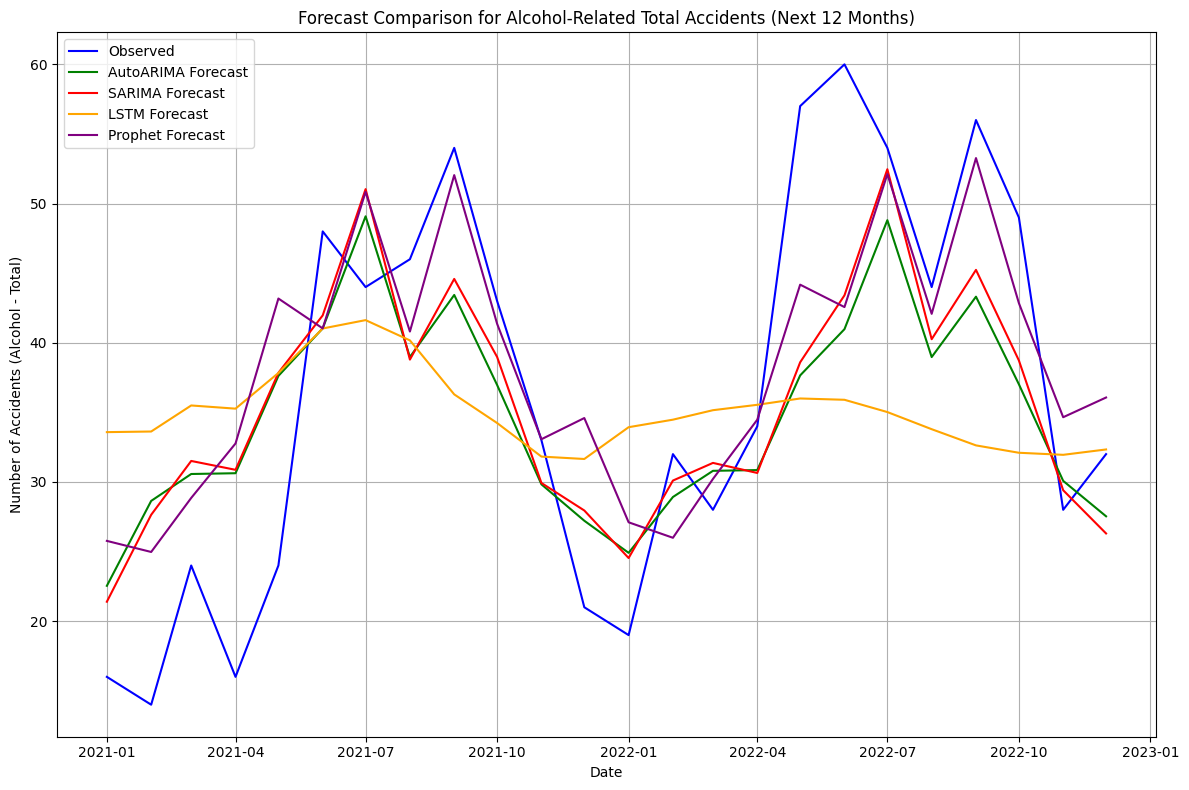

In [33]:
# Plot the metrics on bar charts
models = ['AutoARIMA', 'SARIMA', 'LSTM', 'Prophet']
mae_values = [mae_arima, mae_sarima, mae_lstm, mae_prophet]
rmse_values = [rmse_arima, rmse_sarima, rmse_lstm, rmse_prophet]
r2_values = [r2_arima, r2_sarima, r2_lstm, r2_prophet]

# Plot MAE
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=mae_values, palette='viridis')
plt.title('Model Comparison - Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Models')
plt.show()

# Plot RMSE
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=rmse_values, palette='viridis')
plt.title('Model Comparison - Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.xlabel('Models')
plt.show()

# Plot R^2 Score
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=r2_values, palette='viridis')
plt.title('Model Comparison - R^2 Score')
plt.ylabel('R^2 Score')
plt.xlabel('Models')
plt.show()

# Plot all predictions including Prophet
plt.figure(figsize=(12, 8))
plt.plot(test_alcohol_total_series.index, test_alcohol_total_series, label='Observed', color='blue')
plt.plot(auto_arima_forecast_index, test_forecast_values_arima, label='AutoARIMA Forecast', color='green')
plt.plot(test_forecast_values_sarima.index, test_forecast_values_sarima, label='SARIMA Forecast', color='red')
plt.plot(test_alcohol_total_series.index, test_forecast_values_lstm, label='LSTM Forecast', color='orange')
plt.plot(test_alcohol_total_series.index, forecast_values_prophet, label='Prophet Forecast', color='purple')
plt.xlabel('Date')
plt.ylabel('Number of Accidents (Alcohol - Total)')
plt.title('Forecast Comparison for Alcohol-Related Total Accidents (Next 12 Months)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
import pickle

# Save the best Prophet model
with open('models/prophet_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)